# Introduction

Predicting financial indicators is a holy grail for our society. There is a vast literature on how to do this and the general approach is a time-series one, that is, predict the future of one quantity based on that quantity's past.

We are trying to see if it's possible to complement this approach with data coming from news sources, reasoning that news from the world should directly and indirectly weigh on the performance of such indicators as stocks, employment rate, or inflation.

Please keep in mind that we do not expect to make any significant improvement over state-of-the-art financial analyses (which involve much more complex and refined models). Rather, we are interested in building a scalable and dynamic pipeline that in the future might supplement those already-existing models or give interesting insights.

### This notebook

This is a walkthrough illustrating the typical usage of our package. We will try to predict future S&P500 closing values based on past S&P500 values along with NLP features extracted from the daily-updted GDELT 1.0 (http://www.gdeltproject.org/) event database.

In particular, to scope down the analysis to a minimally viable scalable pipeline, I extract features from the source urls contained in the database (one associated to each event).

For each day, all urls get parsed, tokenized, and stemmed, and then conflated together into a single bag of words. This will constitute one document. After that I may apply a tf-idf or word2vec vectorization (this latter being much favored).

I use the extracted features (plus the same day's closing S&P500) to try and fit various regression models to predict the next day's S&P500 and compare them to a benchmark model (a simple naive model predicting the same for tomorrow as today, plus the average increase or decrease over the last few days).

I also try to predict if tomorrow's index value will rise or fall, given today's news.

For both tasks random forest regressors/classifiers seem promising approaches.

In [1]:
import importlib
import sys
import os
sourcedir=os.getcwd()+"/../source"
if sourcedir not in sys.path:
    sys.path.append(sourcedir)
import numpy as np

In [2]:
#importing our nlp proprocessing module, the reload command is for development
import nlp_preprocessing as nlpp
importlib.reload(nlpp)
#importing our model training module, the reload command is for development
import model_training as mdlt
importlib.reload(mdlt)

<module 'model_training' from '/Users/Maxos/Desktop/Insight_stuff/bigsnippyrepo/maqro/notebooks/../source/model_training.py'>

## The nlp-preprocessing module

The module has two classes for now: one deals with the nlp preprocessing of Google News articles, which are talked about in much more depth in another notebook; the other is the analog for GDELT url data.

Let's explore these classes and their contents.

### The CorpusGoogleNews class

In [3]:
#del datagnews
datagnews=nlpp.CorpusGoogleNews() # nlpp.CorpusGoogleNews('some/data/directory') 

These are the attributes of the initialized class

In [6]:
print(datagnews.raw_articles)
print(datagnews.datadirectory)

{}
../data/


There is one public method for now: it loads files from the data folder

In [7]:
datagnews.data_directory_crawl('AAPL',verbose=1)

Apple Inc
Apple Inc 1-26-17
Apple Inc 1-27-17
Apple Inc 1-30-17
Apple Inc 1-31-17
Apple Inc 2-1-17


which populates datagnews.raw_articles with dataframes like this:

In [8]:
datagnews.raw_articles['Apple Inc 1-30-17'].head()

,body,title,category
0,The first day of public trading with President...,3 Stocks to Watch on Tuesday: Apple Inc. (AAPL...,Apple Inc
1,The first day of public trading with President...,3 Stocks to Watch on Tuesday: Apple Inc. (AAPL...,Apple Inc
2,"The smart home market continues to heat up, an...",Alphabet Inc (GOOGL) Steals AI Expert Back Fro...,Apple Inc
3,"Reportedly, Apple Inc.’s AAPL management is sc...",Apple (AAPL) Set to Meet Government Officials ...,Apple Inc
4,Apple Inc. (AAPL) executives were in India tod...,Apple Close to Signing Deal With Indian Govern...,Apple Inc


### The CorpusGDELT class

Let's initialize the class

In [3]:
#del datagdelt
datagdelt=nlpp.CorpusGDELT(min_ment=500) # min_ment defaults to 1 and cuts off events that have a low number of mentions

Let's have a look at the several attributes that the class contains.

In [10]:
#minimum number of mentions for one event to be used
print('Minimum number of mentions:',datagdelt.minimum_ment)
print('Current directory:',datagdelt.currentdir) # current directory
print('Dates loaded so far:',datagdelt.dates) # dates for which data has been loaded so far
print('Corpus of raw urls',datagdelt.url_corpus)
print('Corpus of tfidf-vectorized docs:')
print(datagdelt.vect_corpus_tfidf)

Minimum number of mentions: 500
Current directory: ../data/GDELT_1.0/
Dates loaded so far: []
Corpus of raw urls []
Corpus of tfidf-vectorized docs:
Empty DataFrame
Columns: []
Index: []


In [11]:
#vowels and consonants
print('Vowels:',datagdelt.vowels)
print('Consonants:',datagdelt.consonants,end=' ')
print()
print('Stemmer:',datagdelt.porter) #stemmer of choice
print('Punctuation:',datagdelt.punctuation) #punctuation regular expression
print('Tokenizer:',datagdelt.re_tokenizer) 
print('Filter for spurious url beginnings:',datagdelt.spurious_beginnings)
print('Filter for stop words:',datagdelt.stop_words)

Vowels: ['a', 'e', 'i', 'o', 'u', 'y']
Consonants: ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'z'] 
Stemmer: <PorterStemmer>
Punctuation: re.compile('[-.?!,":;()|0-9]')
Tokenizer: RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=56)
Filter for spurious url beginnings: re.compile('idind.|idus.|iduk.')
Filter for stop words: {'', 'during', 'which', 've', 'than', 'this', 'yourself', 'few', 'both', 'do', 'then', 'themselves', 'doing', 'how', 'aren', 'off', 'whom', 'own', 'had', 'very', 'why', 'doesn', 'myself', 'hadn', 'by', 'but', 'those', 'mustn', 'shouldn', 'don', 'you', 'my', 'hasn', 'wouldn', 'shan', 'to', 'only', 'that', 'ma', 'again', 'such', 'are', 'any', 'its', 'will', 'has', 'mightn', 'o', 'above', 'theirs', 'below', 'against', 'these', 'he', 'them', 'too', 'and', 'more', 'couldn', 'did', 'down', 'does', 'other', 'there', 'yourselves', 'your', 'd', 'on', 'll', 'just', 'into', 'some', 'didn', 'after', 'him',

In [12]:
print(datagdelt.header,end=' ') #GDELT csv files header, notice the last field has the urls

['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate', 'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode', 'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code', 'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code', 'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode', 'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code', 'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent', 'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type', 'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID', 'ActionGeo_Type', 'ActionGeo_FullName', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code', 'ActionGeo_Lat', 

Now let's see what methods are available and what the pipeline is like.

First we load the urls.

In [4]:
datagdelt.load_urls('20161101','20170222') #the earliest available date is April 1st 2013 = 20130401

 Done!

Now let's look at what the url_corpus attribute looks like

In [5]:
day=5 #select one day
print('There are',len(datagdelt.url_corpus),'elements in it, because we loaded',len(datagdelt.dates),'days!')
print('The loaded day n.',day,'had',len(datagdelt.url_corpus[day-1]) ,'events in it that were mentioned more than',datagdelt.minimum_ment,'times:\n', datagdelt.url_corpus[day-1][:10],'\n etc...')
print('The first event was mentioned',datagdelt.url_corpus[day-1][0][0],'times, the second',datagdelt.url_corpus[day-1][1][0],'times, etc...')

There are 114 elements in it, because we loaded 114 days!
The loaded day n. 5 had 481 events in it that were mentioned more than 500 times:
 [[825, 'http://wtvr.com/2016/11/04/shockoe-bottom-bar-under-scrutiny-for-alleged-racist-dress-code/'], [720, 'http://wtnh.com/2016/11/04/crash-report-school-bus-driver-took-seizure-meds-wife-said/'], [945, 'http://www.kristv.com/story/33633549/drunk-wrong-way-driver-gets-prison-time-for-causing-deadly-crash'], [540, 'http://poststar.com/ap/national/questions-on-christie-role-swirl-after-ex-allies-conviction/article_7704f727-41e3-5cb5-aa4d-e94c07c4aba3.html'], [756, 'http://www.kristv.com/story/33635695/final-push-by-presidential-candidates-targets-2-different-americas'], [609, 'http://www.middevonstar.co.uk/news/national/14845374.Charles_and_Camilla_begin_official_tour_of_the_Middle_East/'], [520, 'http://gwdtoday.com/main.asp?SectionID=64&SubSectionID=239&TM=71114.41'], [504, 'https://www.buzzfeed.com/tanyachen/people-are-outraged-after-glamour-b

We see that many of those urls contain wordings that can be very informative on what's happening in the world and therefore might tell us something about the near future of the markets!!

Now, let's process these messy raw urls! Let's use word2vec:

In [5]:
datagdelt.gdelt_preprocess(vectrz='word2vec',size_w2v=16)

Using word2vec vectorization procedure


2017-02-23 15:55:37,484 : INFO : collecting all words and their counts
2017-02-23 15:55:37,554 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-23 15:55:37,651 : INFO : collected 18286 word types from a corpus of 402413 raw words and 114 sentences
2017-02-23 15:55:37,652 : INFO : Loading a fresh vocabulary
2017-02-23 15:56:12,556 : INFO : min_count=1 retains 18286 unique words (100% of original 18286, drops 0)
2017-02-23 15:56:12,557 : INFO : min_count=1 leaves 402413 word corpus (100% of original 402413, drops 0)
2017-02-23 15:56:12,675 : INFO : deleting the raw counts dictionary of 18286 items
2017-02-23 15:56:12,677 : INFO : sample=0.001 downsamples 26 most-common words
2017-02-23 15:56:12,677 : INFO : downsampling leaves estimated 380477 word corpus (94.5% of prior 402413)
2017-02-23 15:56:12,678 : INFO : estimated required memory for 18286 words and 16 dimensions: 11483608 bytes
2017-02-23 15:56:12,770 : INFO : resetting layer weights
2017-02-23 1

which gives

In [7]:
datagdelt.word2vec_corpus.head(10)

,w2v_1,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9
news_date,,,,,,,,,,,,,,,,
20161101,0.165087,0.468019,-0.010375,-0.176782,-0.166323,0.359283,-0.344207,-0.183213,0.009851,0.291588,-0.046167,-0.074839,-0.504264,0.169356,0.130914,0.143513
20161102,0.102542,0.442412,-0.099021,-0.182619,-0.141894,0.341978,-0.385311,-0.234497,0.016997,0.293796,-0.056177,-0.029937,-0.515226,0.178492,0.090224,0.118111
20161103,0.135619,0.452530,-0.066780,-0.158268,-0.164568,0.326634,-0.360228,-0.215594,0.016726,0.292170,-0.046462,-0.057232,-0.519043,0.204743,0.124830,0.138971
20161104,0.109827,0.449690,-0.060406,-0.184516,-0.143363,0.341008,-0.369758,-0.205175,0.007495,0.313282,-0.055131,-0.029349,-0.520874,0.189917,0.095501,0.117317
20161105,0.143273,0.477831,-0.044463,-0.177028,-0.171535,0.328301,-0.338856,-0.190211,-0.026833,0.311630,-0.058200,-0.047064,-0.500675,0.204456,0.140284,0.118461
20161106,0.105819,0.416706,-0.092857,-0.164963,-0.165827,0.316391,-0.358254,-0.204483,0.012215,0.328438,-0.020067,-0.032634,-0.542135,0.231038,0.100778,0.120946
20161107,0.148476,0.490989,-0.045819,-0.173995,-0.185121,0.326168,-0.326672,-0.186845,-0.000539,0.310929,-0.077235,-0.011078,-0.496442,0.195048,0.157476,0.100835
20161108,0.179701,0.507083,0.000172,-0.172458,-0.188758,0.338139,-0.317917,-0.156479,-0.013063,0.289262,-0.070929,-0.038262,-0.493247,0.170664,0.168409,0.119121
20161109,0.282015,0.510554,0.028032,-0.115850,-0.262162,0.300052,-0.260741,-0.091417,-0.020058,0.218182,-0.052073,-0.089851,-0.449390,0.201576,0.279772,0.175627


BOOM! Now we have all of our datapoints with their nlp features neatly arranged in a pandas dataframe, ready for processing. Mission accomplished!

If we try to run this expensive preprocessing again on the same exact data...

In [8]:
datagdelt.gdelt_preprocess(vectrz='word2vec',size_w2v=16)

Using word2vec vectorization procedure
Nothing to be done, dataframes are up to date


Yay for savings!

If you would like to see the time-series evolution of these features, here you go:

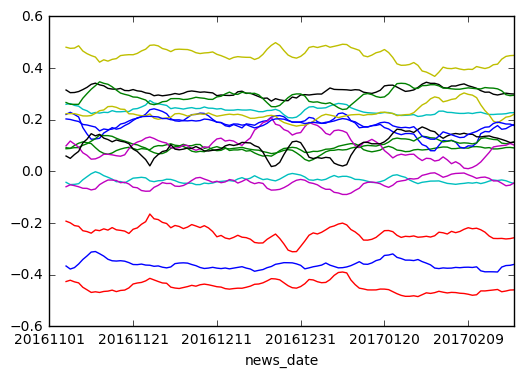

In [18]:
import pandas as pd
%matplotlib inline
#datagdelt.word2vec_corpus.plot()
datagdelt.word2vec_corpus.rolling(window=5,center=False).mean().plot(legend=False)

Now we initialize the model training class, feeding it the dataframe from the nlp processing

## The model training module
This section covers model training, validation, and testing, from our model_training module

We initialize a class instance by loading into it two lists: one of names of your choosing and one of dataframes, which in this case is the output form the previous module above, datagdelt.vect_corpus_tfidf.

In [6]:
import model_training as mdlt
importlib.reload(mdlt)
tet=mdlt.StockPrediction([['word2vec'],[datagdelt.word2vec_corpus],[datagdelt.w2vec_model]],update=True)

And now, for the real deal: training and validation!
The following two methods perform that in a very general manner. You are free to decide what regression/classification model to choose, as well as the values of the hyperparameters (please see the module documentation in model_training.py for details on how to pass the hyperparameters). In short, automated tuning will consist of choosing the values for the hyperparameters that minimize the average root mean squared on the validation datasets)

Let's try an L1 linear regressor which is trying to predict the increase/decrease of tomorrow's S&P index over today's. We test on the last 20 days and validate/tune, for each test case, over the previous 20 more days, training over yet 30 earlier dates. As for the hyperparameters, we are letting our regularization parameter be searched for in the 0.001-7000 range and we allow for 50 iterations of the optimal parameter search.

In [7]:
tet.auto_ts_val_test_reg('word2vec','lasso',[['alpha',[0.001,7000.,60.]]],parm_search_iter=50,n_folds_val=20,
                         past_depth=30,n_folds_test=20,scaling=False,differential=False,notest=False,verbose=False,
                         eqdiff=False)

//anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameter choices: (26.43679869829576,)
model_test_rmse: 18.885 benchmark_test_rmse: 15.294
best parameter choices: (2.928670189300411,)
model_test_rmse: 1.430 benchmark_test_rmse: 4.965
best parameter choices: (0.9664510467126172,)
model_test_rmse: 1.786 benchmark_test_rmse: 5.179
best parameter choices: (0.43209981481481485,)
model_test_rmse: 14.341 benchmark_test_rmse: 16.891
best parameter choices: (1.3131004705761313,)
model_test_rmse: 1.973 benchmark_test_rmse: 4.849
best parameter choices: (1.3131004705761313,)
model_test_rmse: 0.692 benchmark_test_rmse: 2.060
best parameter choices: (1.3131004705761313,)
model_test_rmse: 1.328 benchmark_test_rmse: 1.407
best parameter choices: (0.38888903333333336,)
model_test_rmse: 16.611 benchmark_test_rmse: 13.885
best parameter choices: (0.38888903333333336,)
model_test_rmse: 4.512 benchmark_test_rmse: 7.761
best parameter choices: (0.38888903333333336,)
model_test_rmse: 0.800 benchmark_test_rmse: 2.262
best parameter choices: (0.43209

[(7.1910088895790976, 5.9874440495127965),
 (6.9204902668871906, 4.5852421643687409)]

Well, doing worse than benchmark... The model coefficients are:

In [8]:
feat_imp=tet.models['word2vec'].coef_
feat_imp
#these are the feature importances for the lasso classifier

array([ 0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.97775417])

...which isn't surprising. As we said at the beginning, the most important feature should have been today's closing, and it was, entirely offuscating everything else. Also, remember that the features aren't scaled so the large coefficients of two of the word2vec features are of little significance.

If one had gotten a reasonable result, they might want to play with feature importances to try and see which stems actually were the most significant. It can be done as follows

In [13]:
model=tet.w2v_models['word2vec']
model.wv.similar_by_vector(feat_imp[:-2])

2017-02-23 09:57:57,285 : INFO : precomputing L2-norms of word weight vectors


[('groveland', 0.0),
 ('smokn', 0.0),
 ('hayborough', 0.0),
 ('werk', 0.0),
 ('silverwat', 0.0),
 ('sutter', 0.0),
 ('strychnin', 0.0),
 ('blythevil', 0.0),
 ('lesion', 0.0),
 ('firstev', 0.0)]

which is supposed to show the words that are most positively correlated with the S&P500 index

In [9]:
tet.auto_ts_val_test_reg('word2vec','ridge',[['alpha',[100.,70000000.,600.]]],parm_search_iter=50,n_folds_val=20,
                         past_depth=30,n_folds_test=20,scaling=True,differential=True,notest=False,verbose=False,
                         eqdiff=False)

best parameter choices: (1784997550.0,)
model_test_rmse: 15.294 benchmark_test_rmse: 15.294
best parameter choices: (1784997550.0,)
model_test_rmse: 4.965 benchmark_test_rmse: 4.965
best parameter choices: (1784997550.0,)
model_test_rmse: 5.179 benchmark_test_rmse: 5.179
best parameter choices: (1784997550.0,)
model_test_rmse: 16.891 benchmark_test_rmse: 16.891
best parameter choices: (1784997550.0,)
model_test_rmse: 4.849 benchmark_test_rmse: 4.849
best parameter choices: (1784997550.0,)
model_test_rmse: 2.060 benchmark_test_rmse: 2.060
best parameter choices: (1784997550.0,)
model_test_rmse: 1.407 benchmark_test_rmse: 1.407
best parameter choices: (1784997550.0,)
model_test_rmse: 13.885 benchmark_test_rmse: 13.885
best parameter choices: (1784997550.0,)
model_test_rmse: 7.761 benchmark_test_rmse: 7.761
best parameter choices: (1784997550.0,)
model_test_rmse: 2.262 benchmark_test_rmse: 2.262
best parameter choices: (1784997550.0,)
model_test_rmse: 1.158 benchmark_test_rmse: 1.158
best

[(6.9204901155136209, 4.5852424301990213),
 (6.9204902668871906, 4.5852421643687409)]

which basically falls back on the benchmark, due to heavy L2 regularization

How about we try a random forest regressor instead? We are letting our tuning select any combination among 1 value for the number of estimators, 6 for the maximum number of features used for splitting, and we allow a maximum depth from 4 to 7.

In [53]:
tet.auto_ts_val_test_reg('word2vec','rfreg',[['n_estim',{20,}],['max_feat',{9,10,15,16,17,18}],['max_depth',{4,5,6,7}]],
                         parm_search_iter=1,n_folds_val=20,past_depth=30,n_folds_test=20,scaling=True,differential=True,
                         verbose=False,notest=False,eqdiff=False)

best parameter choices: (20, 17, 6)
model_test_rmse: 18.420 benchmark_test_rmse: 12.080
best parameter choices: (20, 16, 6)
model_test_rmse: 23.476 benchmark_test_rmse: 15.294
best parameter choices: (20, 9, 4)
model_test_rmse: 4.733 benchmark_test_rmse: 4.965
best parameter choices: (20, 15, 5)
model_test_rmse: 4.237 benchmark_test_rmse: 5.179
best parameter choices: (20, 18, 7)
model_test_rmse: 8.183 benchmark_test_rmse: 16.891
best parameter choices: (20, 9, 7)
model_test_rmse: 1.483 benchmark_test_rmse: 4.849
best parameter choices: (20, 10, 6)
model_test_rmse: 5.363 benchmark_test_rmse: 2.060
best parameter choices: (20, 9, 7)
model_test_rmse: 7.205 benchmark_test_rmse: 1.407
best parameter choices: (20, 15, 5)
model_test_rmse: 17.773 benchmark_test_rmse: 13.885
best parameter choices: (20, 18, 7)
model_test_rmse: 2.921 benchmark_test_rmse: 7.761
best parameter choices: (20, 17, 6)
model_test_rmse: 3.904 benchmark_test_rmse: 2.262
best parameter choices: (20, 18, 5)
model_test_rms

[(8.0757377158441379, 6.2519882354033287),
 (7.2273715043417273, 4.7130879952476494)]

In [54]:
feat_imp=tet.models['word2vec'].feature_importances_
feat_imp
#these are the feature importances for a random forest classifier

array([ 0.03137145,  0.05368506,  0.03035894,  0.39608781,  0.00229447,
        0.04623422,  0.01598908,  0.03340178,  0.02829764,  0.06379287,
        0.01956722,  0.0217689 ,  0.03534378,  0.08044819,  0.05350895,
        0.01836402,  0.00138395,  0.06810169])

Ok... How about good old knn??

In [13]:
tet.auto_ts_val_test_reg('word2vec','knnreg',[['numb_nn',{2,3,4,5,6,7,8,9,10,11,12,13}]],parm_search_iter=1,n_folds_val=20,
                         n_folds_test=20,past_depth=30,scaling=True,differential=True,notest=False,verbose=False,
                         eqdiff=False)

best parameter choices: (13,)
model_test_rmse: 17.562 benchmark_test_rmse: 15.294
best parameter choices: (13,)
model_test_rmse: 6.912 benchmark_test_rmse: 4.965
best parameter choices: (13,)
model_test_rmse: 4.015 benchmark_test_rmse: 5.179
best parameter choices: (13,)
model_test_rmse: 15.276 benchmark_test_rmse: 16.891
best parameter choices: (12,)
model_test_rmse: 4.105 benchmark_test_rmse: 4.849
best parameter choices: (12,)
model_test_rmse: 0.640 benchmark_test_rmse: 2.060
best parameter choices: (12,)
model_test_rmse: 1.226 benchmark_test_rmse: 1.407
best parameter choices: (12,)
model_test_rmse: 13.846 benchmark_test_rmse: 13.885
best parameter choices: (12,)
model_test_rmse: 5.096 benchmark_test_rmse: 7.761
best parameter choices: (12,)
model_test_rmse: 0.953 benchmark_test_rmse: 2.262
best parameter choices: (11,)
model_test_rmse: 1.954 benchmark_test_rmse: 1.158
best parameter choices: (7,)
model_test_rmse: 8.830 benchmark_test_rmse: 10.470
best parameter choices: (7,)
model

[(6.2304819331643326, 4.5515196868812735),
 (6.9204902668871906, 4.5852421643687409)]

Surprisingly not bad!

Now, if we want to get a prediction for today, we toggle the 'notest' attribute to True

In [14]:
tet.auto_ts_val_test_reg('word2vec','knnreg',[['numb_nn',{2,3,4,5,6,7,8,9,10,11,12,13}]],parm_search_iter=1,n_folds_val=20,
                         n_folds_test=20,past_depth=30,scaling=True,differential=True,notest=True,verbose=False,
                         eqdiff=False)

array([ 2371.69004586])

Cool! En passant, here's the S&P500 behavior over the last 70+ days

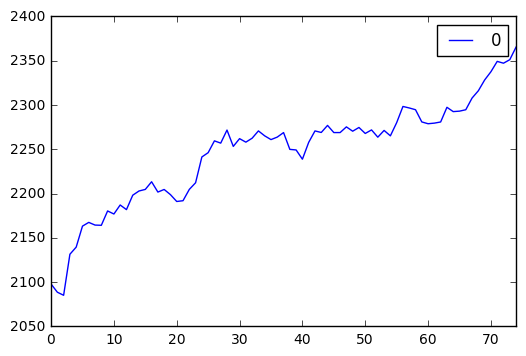

In [43]:
pd.DataFrame(tet.ydata['word2vec'][0][:,0]).rolling(window=1,center=False).mean().plot()

Let's see if classifying tomorrow's value going up or down will do us any better...

In [35]:
tet.auto_ts_val_test_reg('word2vec','mlpreg',[['activation',{'relu','tanh'}],['layers_size',{(10,5),(20,5),(10,5,5)}]],
                           parm_search_iter=1,past_depth=30,n_folds_val=20,n_folds_test=20,scaling=False,notest=False,
                           verbose=False,eqdiff=False,differential=True)

//anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


best parameter choices: ('tanh', (10, 5, 5))
model_test_rmse: 16.142 benchmark_test_rmse: 15.294
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 3.950 benchmark_test_rmse: 4.965
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 4.741 benchmark_test_rmse: 5.179
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 16.685 benchmark_test_rmse: 16.891
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 4.040 benchmark_test_rmse: 4.849
best parameter choices: ('tanh', (10, 5, 5))
model_test_rmse: 1.920 benchmark_test_rmse: 2.060
best parameter choices: ('tanh', (10, 5, 5))
model_test_rmse: 1.386 benchmark_test_rmse: 1.407
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 14.543 benchmark_test_rmse: 13.885
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 7.208 benchmark_test_rmse: 7.761
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 2.270 benchmark_test_rmse: 2.262
best parameter choices: ('tanh', (10, 5))
model_test_rmse: 1.016 

[(6.9740931433457716, 4.8961619848329079),
 (6.9204902668871906, 4.5852421643687409)]

In [15]:
tet.auto_ts_val_test_class('word2vec','logreg',[['l1orl2?',{'l1','l2'}],['C',[0.0001,100.,0.3]]],
                           parm_search_iter=10,n_folds_val=20,n_folds_test=20,past_depth=30,scaling=False,notest=False,
                           verbose=False)

best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 5.5555699999999995)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,

[(array([[ 0.75,  0.9 ,  0.65]]),
  array([[ 0.4330127,  0.3      ,  0.4769696]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]

Hmm, not too bad. Our average accuracy (=F1 in this case) is ~0.65 against ~0.65 of the benchmark. However our precision is quite larger at ~0.9 vs ~0.65.

In [16]:
tet.auto_ts_val_test_class('word2vec','logreg',[['l1orl2?',{'l1','l2'}],['C',[0.0001,100.,0.3]]],
                           parm_search_iter=30,n_folds_val=20,n_folds_test=20,past_depth=30,scaling=True,notest=False,
                           verbose=False)

best parameter choices: ('l2', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l2', 22.2223)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0

[(array([[ 0.65,  0.85,  0.5 ]]),
  array([[ 0.4769696 ,  0.35707142,  0.5       ]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]

In [17]:
tet.auto_ts_val_test_class('word2vec','rfclass',[['n_estim',{20,}],['max_feat',{9,10,15,16,17,18}],
                                                 ['max_depth',{4,5,6,7}]],parm_search_iter=1,n_folds_val=20,
                           past_depth=30,n_folds_test=20,scaling=False,verbose=False,notest=False)

best parameter choices: (20, 15, 7)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 9, 4)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 10, 4)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 10, 5)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 17, 4)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 10, 7)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 16, 5)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 16, 7)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 10, 4)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choic

[(array([[ 0.8 ,  0.95,  0.75]]),
  array([[ 0.4       ,  0.21794495,  0.4330127 ]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]

In [18]:
tet.auto_ts_val_test_class('word2vec','rfclass',[['n_estim',{20,}],['max_feat',{9,10,15,16,17,18}],
                                                 ['max_depth',{4,5,6,7}]],parm_search_iter=1,n_folds_val=20,
                           past_depth=30,n_folds_test=20,scaling=False,verbose=False,notest=True)

array([ 0.])

In [22]:
tet.auto_ts_val_test_class('word2vec','knnclass',[['n_neighbor',{1,2,3,4,5,6,7,8,9,10,11}]],parm_search_iter=1,
                           n_folds_val=20,past_depth=30,n_folds_test=20,scaling=True,verbose=False,notest=False)

best parameter choices: (4,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (4,)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (4,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (4,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (4,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (4,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (4,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (1,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (1,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (1,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,

[(array([[ 0.8 ,  0.85,  0.65]]),
  array([[ 0.4       ,  0.35707142,  0.4769696 ]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]

In [23]:
tet.auto_ts_val_test_class('word2vec','knnclass',[['n_neighbor',{1,2,3,4,5,6,7,8,9,10,11}]],parm_search_iter=1,
                           n_folds_val=20,past_depth=30,n_folds_test=20,scaling=True,verbose=False,notest=True)

array([ 1.])

Wow, that was bad... Maybe SVM? Stay tuned and feel free to play with our tool!

In [25]:
tet.auto_ts_val_test_class('word2vec','adabclass',[['n_estimators',{6,7,8,9,10,11,12}]],
                           parm_search_iter=2,past_depth=30,n_folds_val=20,n_folds_test=20,scaling=False,notest=False,
                           verbose=False)

best parameter choices: (9,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (8,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (8,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (8,)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (8,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (8,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (8,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (12,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (8,)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (12,)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,pre

[(array([[ 0.6 ,  0.95,  0.55]]),
  array([[ 0.48989795,  0.21794495,  0.49749372]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]

In [ ]:
tet.auto_ts_val_test_class('word2vec','adabclass',[['n_estimators',{6,7,8,9,10,11,12}]],
                           parm_search_iter=2,past_depth=30,n_folds_val=20,n_folds_test=20,scaling=False,notest=False,
                           verbose=False)

In [31]:
tet.auto_ts_val_test_class('word2vec','mlpclass',[['activation',{'relu','tanh'}],['layers_size',{(10,5),(20,5),(10,5,5)}]],
                           parm_search_iter=1,past_depth=30,n_folds_val=20,n_folds_test=20,scaling=False,notest=False,
                           verbose=False)

best parameter choices: ('relu', (10, 5))
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]


//anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


best parameter choices: ('relu', (10, 5))
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('relu', (20, 5))
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('relu', (20, 5))
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('relu', (10, 5))
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('relu', (10, 5, 5))
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('relu', (10, 5, 5))
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('relu', (20, 5))
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('relu', (10, 5))
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('relu', (10, 5, 5))
test_rec,prec,F1: [1.0, 1.0, 

[(array([[ 0.85,  0.8 ,  0.65]]),
  array([[ 0.35707142,  0.4       ,  0.4769696 ]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]

In [32]:
tet.auto_ts_val_test_class('word2vec','rfclass',[['n_estim',{20,}],['max_feat',{9,10,15,16,17,18}],
                                                 ['max_depth',{4,5,6,7}]],parm_search_iter=1,n_folds_val=20,
                           past_depth=30,n_folds_test=20,scaling=False,verbose=False,notest=False)

best parameter choices: (20, 17, 4)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 9, 4)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 15, 7)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 16, 6)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 16, 6)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: (20, 15, 4)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 10, 7)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 9, 7)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (20, 9, 7)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices

[(array([[ 0.65,  0.85,  0.5 ]]),
  array([[ 0.4769696 ,  0.35707142,  0.5       ]])),
 (array([[ 1.  ,  0.65,  0.65]]),
  array([[ 0.       ,  0.4769696,  0.4769696]]))]